In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import files


In [16]:
uploaded = files.upload()

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

print("Dataset Shape:", df.shape)
display(df.head())


Saving Stock_Market_Time_Series_Data.csv to Stock_Market_Time_Series_Data.csv
Dataset Shape: (8678, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/1986,211.279999,211.279999,208.929993,209.589996,209.589996,98960000
1,1/3/1986,209.589996,210.880005,209.509995,210.880005,210.880005,105000000
2,1/6/1986,210.880005,210.979996,209.929993,210.649994,210.649994,99610000
3,1/7/1986,210.649994,213.800003,210.649994,213.800003,213.800003,153000000
4,1/8/1986,213.800003,214.570007,207.490005,207.970001,207.970001,180300000


In [17]:
def prepare_features(df):
    df = df.copy()
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")
    if "Close" not in df.columns:
        raise ValueError("Dataset must contain 'Close' column")

    df["return"] = df["Close"].pct_change().fillna(0)
    df["ma5"] = df["Close"].rolling(window=5).mean().fillna(method="bfill")
    df["ma20"] = df["Close"].rolling(window=20).mean().fillna(method="bfill")
    df["volatility"] = df["return"].rolling(window=20).std().fillna(method="bfill")

    df = df.replace([np.inf,-np.inf], np.nan).fillna(0)
    X = df.select_dtypes(include=[np.number])
    return df, X


In [18]:
CONTAMINATION = 0.02
TEST_SIZE = 0.2
RANDOM_SEED = 42

def train_and_evaluate(df):
    df_raw, X_numeric = prepare_features(df)
    n = len(X_numeric)
    split_idx = int(n*(1-TEST_SIZE))

    X_train_df, X_test_df = X_numeric.iloc[:split_idx], X_numeric.iloc[split_idx:]
    scaler = StandardScaler()
    scaler.fit(X_train_df)
    X_train, X_test = scaler.transform(X_train_df), scaler.transform(X_test_df)

    # Isolation Forest
    iso = IsolationForest(contamination=CONTAMINATION, random_state=RANDOM_SEED)
    iso.fit(X_train)
    iso_y = (iso.predict(X_test)==-1).astype(int)

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20, contamination=CONTAMINATION, novelty=True)
    lof.fit(X_train)
    lof_y = (lof.predict(X_test)==-1).astype(int)

    # Autoencoder
    inp = keras.Input(shape=(X_train.shape[1],))
    x = layers.Dense(16, activation="relu")(inp)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(4, activation="relu")(x)
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(X_train.shape[1], activation="linear")(x)
    ae = keras.Model(inp, out)
    ae.compile(optimizer="adam", loss="mse")

    ae.fit(X_train, X_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)
    recon_test = np.mean(np.square(ae.predict(X_test)-X_test), axis=1)
    threshold = np.percentile(recon_test, 100*(1-CONTAMINATION))
    ae_y = (recon_test > threshold).astype(int)

    # Synthetic labels (only for metrics demo)
    k = max(1,int(len(X_test)*CONTAMINATION))
    y_test = np.zeros(len(X_test))
    y_test[:k]=1
    np.random.shuffle(y_test)

    # Collect metrics
    metrics = {}
    for model, pred in zip(
        ["IsolationForest","LocalOutlierFactor","Autoencoder"],
        [iso_y, lof_y, ae_y]
    ):
        prec = precision_score(y_test, pred, zero_division=0)
        rec = recall_score(y_test, pred, zero_division=0)
        f1 = f1_score(y_test, pred, zero_division=0)
        ratio = pred.mean()
        metrics[model] = {
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "Anomaly_Ratio": ratio
        }

    return X_test_df, iso_y, lof_y, ae_y, metrics


In [19]:
X_test_df, iso_y, lof_y, ae_y, metrics = train_and_evaluate(df)

comparison = []
for model, vals in metrics.items():
    comparison.append([
        model,
        vals["Precision"], vals["Recall"], vals["F1-Score"], vals["Anomaly_Ratio"]
    ])

comparison_df = pd.DataFrame(
    comparison,
    columns=["Model","Precision","Recall","F1-Score","Anomaly_Ratio"]
)
display(comparison_df)

comparison_df.to_csv("model_comparison.csv", index=False)

best_row = comparison_df.iloc[comparison_df["F1-Score"].argmax()]
print(f"Best model: {best_row['Model']} (F1={best_row['F1-Score']:.3f})")


/tmp/ipython-input-1059467829.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["ma5"] = df["Close"].rolling(window=5).mean().fillna(method="bfill")
/tmp/ipython-input-1059467829.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["ma20"] = df["Close"].rolling(window=20).mean().fillna(method="bfill")
/tmp/ipython-input-1059467829.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["volatility"] = df["return"].rolling(window=20).std().fillna(method="bfill")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Model,Precision,Recall,F1-Score,Anomaly_Ratio
0,IsolationForest,0.019585,1.000000,0.038418,1.000000
1,LocalOutlierFactor,0.019808,0.970588,0.038824,0.959677
2,Autoencoder,0.028571,0.029412,0.028986,0.020161


Best model: LocalOutlierFactor (F1=0.039)


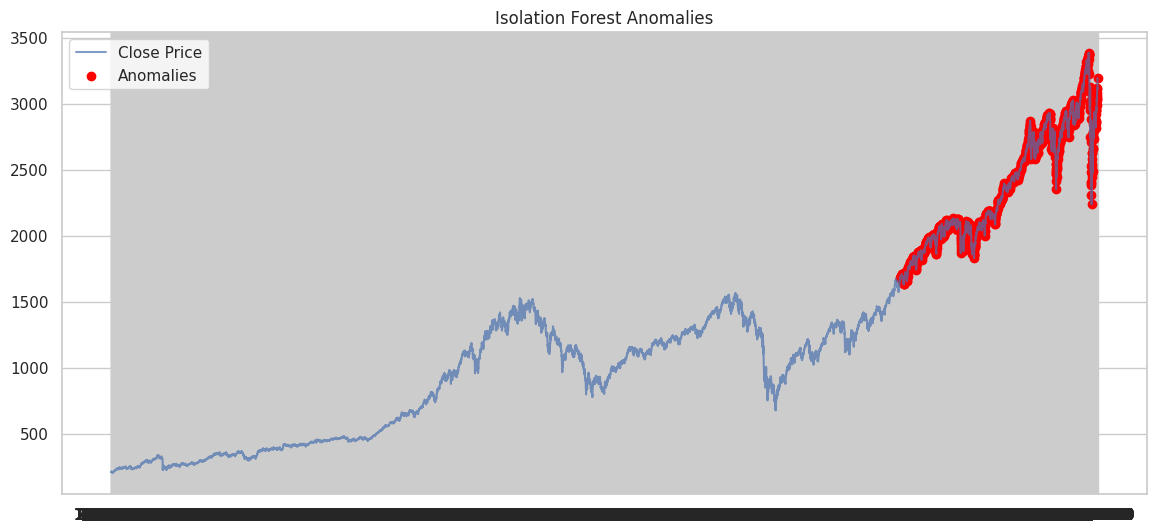

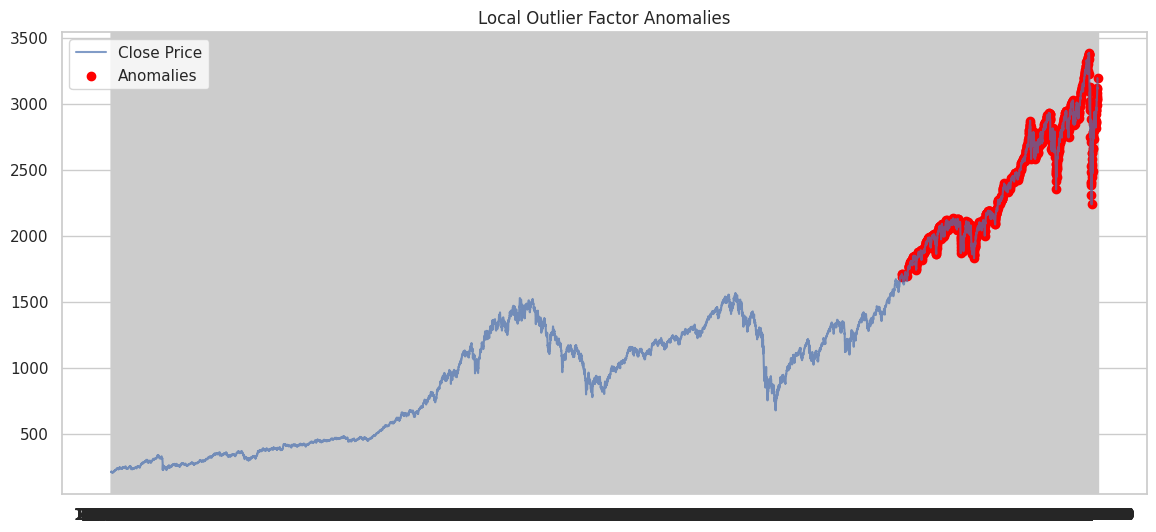

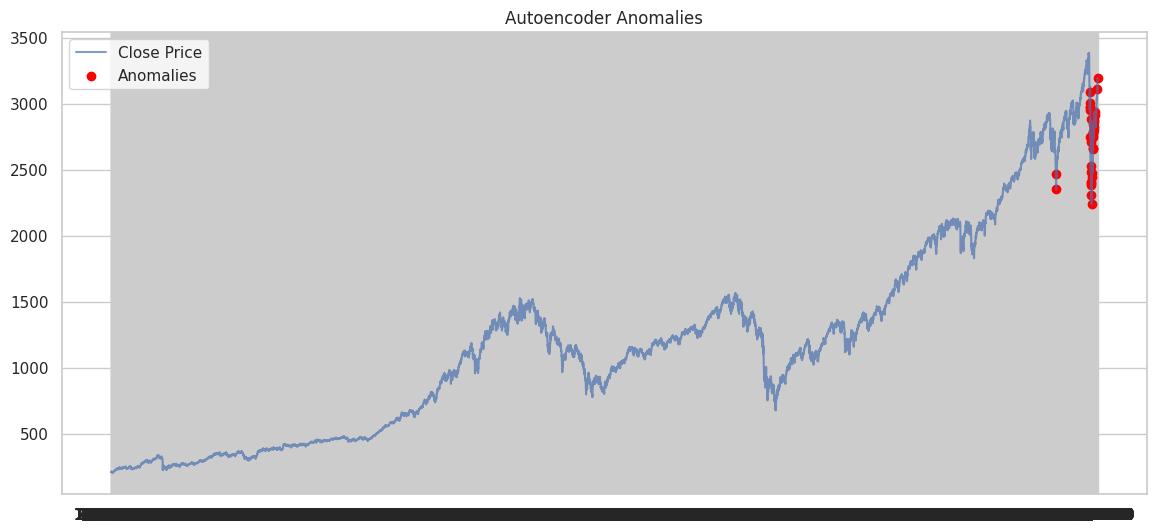

In [20]:
def plot_anomalies(df, anomalies, title):
    plt.figure(figsize=(14,6))
    plt.plot(df["Date"], df["Close"], label="Close Price", alpha=0.7)
    plt.scatter(df["Date"].iloc[-len(anomalies):][anomalies==1],
                df["Close"].iloc[-len(anomalies):][anomalies==1],
                color="red", label="Anomalies")
    plt.title(title)
    plt.legend()
    plt.show()

plot_anomalies(df, iso_y, "Isolation Forest Anomalies")
plot_anomalies(df, lof_y, "Local Outlier Factor Anomalies")
plot_anomalies(df, ae_y, "Autoencoder Anomalies")
